In [7]:

import pandas as pd
# testing the subtract model
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [8]:

class MaskedEmbedding(keras.layers.Layer):
    def __init__(self, mask_token=-1., pad_token=-2., name='masked_embedding'):
        super().__init__(name=name)
        self.mask_token = mask_token
        self.pad_token = pad_token

    def call(self, x, mask):
        """
        Args:
            x: Input tensor of shape (B, N, D)
            mask: Tensor of shape (B, N)
        Returns:
            Tensor with masked positions set to zero.
        """
        mask = tf.cast(mask, tf.float32)
        mask = tf.where((mask == self.pad_token) | (mask == self.mask_token), 0., 1.)
        return x * mask[:, :, tf.newaxis]  # Apply mask to zero out positions


class PositionalEncoding(keras.layers.Layer):
    """
    Sinusoidal Positional Encoding layer that applies encodings
    only to non-masked tokens.

    Args:
        embed_dim (int): Dimension of embeddings (must match input last dim).
        max_len (int): Maximum sequence length expected (used to precompute encodings).
    """

    def __init__(self, embed_dim, pos_range=100, mask_token=-1., pad_token=-2., name='positional_encoding'):
        super().__init__(name=name)
        self.embed_dim = embed_dim
        self.pos_range = pos_range
        self.mask_token = mask_token
        self.pad_token = pad_token

    def build(self, x):
        # Create (1, pos_range, embed_dim) encoding matrix
        pos = tf.range(self.pos_range, dtype=tf.float32)[:, tf.newaxis]  # (pos_range, 1)
        i = tf.range(self.embed_dim, dtype=tf.float32)[tf.newaxis, :]  # (1, embed_dim)
        #angle_rates = 1 / tf.pow(300.0, (2 * (i // 2)) / tf.cast(self.embed_dim, tf.float32))
        angle_rates = tf.pow(300.0, -(2 * tf.floor(i / 2)) / tf.cast(self.embed_dim, tf.float32))
        angle_rads = pos * angle_rates  # (pos_range, embed_dim)

        # Apply sin to even indices, cos to odd indices
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)  # (max_len, embed_dim)
        pos_encoding = pos_encoding[tf.newaxis, ...]  # (1, max_len, embed_dim)
        self.pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x, mask):
        """
        Args:
            x: Input tensor of shape (B, N, D)
            mask: Tensor of shape (B,N)
        Returns:
            Tensor with positional encodings added for masked and non padded tokens.
        """
        seq_len = tf.shape(x)[1]
        pe = self.pos_encoding[:, :seq_len, :]  # (1, N, D)
        mask = tf.cast(mask[:, :, tf.newaxis], tf.float32)  # (B, N, 1)
        mask = tf.where(mask == self.pad_token, 0., 1.)
        pe = pe * mask  # zero out positions where mask is 0

        return x + pe

class AttentionLayer(keras.layers.Layer):
    """
    Custom multi-head attention layer supporting self- and cross-attention.

    Args:
        query_dim (int): Input feature dimension for query.
        context_dim (int): Input feature dimension for context (key and value).
        output_dim (int): Output feature dimension.
        type (str): 'self' or 'cross'.
        heads (int): Number of attention heads.
        resnet (bool): Whether to use residual connection.
        return_att_weights (bool): Whether to return attention weights.
        name (str): Layer name.
        epsilon (float): Epsilon for layer normalization.
        gate (bool): Whether to use gating mechanism.
        mask_token (float): Value for masked tokens.
        pad_token (float): Value for padded tokens.
    """
    def __init__(self, query_dim, context_dim, output_dim, type, heads=4,
                 resnet=True, return_att_weights=False, name='attention',
                 epsilon=1e-6, gate=True, mask_token=-1., pad_token=-2.):
        super().__init__(name=name)
        assert isinstance(query_dim, int) and isinstance(context_dim, int) and isinstance(output_dim, int)
        assert type in ['self', 'cross']
        if resnet:
            assert query_dim == output_dim
        self.query_dim = query_dim
        self.context_dim = context_dim
        self.output_dim = output_dim
        self.type = type
        self.heads = heads
        self.resnet = resnet
        self.return_att_weights = return_att_weights
        self.epsilon = epsilon
        self.gate = gate
        self.mask_token = mask_token
        self.pad_token = pad_token
        self.att_dim = output_dim // heads  # Attention dimension per head

    def build(self, input_shape):
        # Projection weights
        self.q_proj = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'q_proj_{self.name}')
        self.k_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'k_proj_{self.name}')
        self.v_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'v_proj_{self.name}')
        if self.gate:
            self.g = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                     initializer='random_uniform', trainable=True, name=f'gate_{self.name}')
        self.norm = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln_{self.name}')
        if self.type == 'cross':
            self.norm_context = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln_context_{self.name}')
        self.norm_out = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln_out_{self.name}')
        if self.resnet:
            self.norm_resnet = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln_resnet_{self.name}')
        self.out_w = self.add_weight(shape=(self.heads * self.att_dim, self.output_dim),
                                     initializer='random_normal', trainable=True, name=f'outw_{self.name}')
        self.out_b = self.add_weight(shape=(self.output_dim,), initializer='zeros',
                                     trainable=True, name=f'outb_{self.name}')
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.att_dim, tf.float32))

    def call(self, x, mask, context=None, context_mask=None):
        """
        Args:
            x: Tensor of shape (B, N, query_dim) for query.
            mask: Tensor of shape (B, N).
            context: Tensor of shape (B, M, context_dim) for key/value in cross-attention.
            context_mask: Tensor of shape (B, M) for context.
        """
        mask = tf.cast(mask, tf.float32)
        if self.type == 'self':
            context = x
            context_mask = mask
            q_input = k_input = v_input = self.norm(x)
            mask_q = mask_k = tf.where(mask == self.pad_token, 0., 1.)
        else:
            assert context is not None and context_mask is not None
            q_input = self.norm(x)
            k_input = v_input = self.norm_context(context)
            mask_q = tf.where(mask == self.pad_token, 0., 1.)
            mask_k = tf.where(context_mask == self.pad_token, 0., 1.)

        # Project query, key, value
        q = tf.einsum('bnd,hde->bhne', q_input, self.q_proj)
        k = tf.einsum('bmd,hde->bhme', k_input, self.k_proj)
        v = tf.einsum('bmd,hde->bhme', v_input, self.v_proj)

        # Compute attention scores
        att = tf.einsum('bhne,bhme->bhnm', q, k) * self.scale
        mask_q_exp = tf.expand_dims(mask_q, axis=1)
        mask_k_exp = tf.expand_dims(mask_k, axis=1)
        attention_mask = tf.einsum('bqn,bkm->bqnm', mask_q_exp, mask_k_exp)
        attention_mask = tf.broadcast_to(attention_mask, tf.shape(att))
        att += (1.0 - attention_mask) * -1e9
        att = tf.nn.softmax(att, axis=-1) * attention_mask

        # Compute output
        out = tf.einsum('bhnm,bhme->bhne', att, v)
        if self.gate:
            g = tf.einsum('bnd,hde->bhne', q_input, self.g)
            g = tf.nn.sigmoid(g)
            out *= g

        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, [tf.shape(x)[0], tf.shape(x)[1], self.heads * self.att_dim])
        out = tf.matmul(out, self.out_w) + self.out_b

        if self.resnet:
            out += x
            out = self.norm_resnet(out)
        out = self.norm_out(out)
        mask_exp = tf.expand_dims(mask_q, axis=-1)
        out *= mask_exp

        return (out, att) if self.return_att_weights else out

class AddGaussianNoise(layers.Layer):
    def __init__(self, std=0.1, **kw): super().__init__(**kw); self.std = std

    def call(self, x, training=None):
        if training: return x + tf.random.normal(tf.shape(x), stddev=self.std)
        return x


In [9]:
@tf.function
def select_indices(ind, n, m_range):
    """
    Select top-n indices from `ind` (descending sorted) such that:
    - First index is always selected.
    - Each subsequent index has a distance from all previously selected
      indices between m_range[0] and m_range[1], inclusive.
    Args:
        ind: Tensor of shape (B, N) with descending sorted indices.
        n: Number of indices to select.
        m_range: List or tuple [min_distance, max_distance]
    Returns:
        Tensor of shape (B, n) with selected indices per batch.
    """
    m_min = tf.constant(m_range[0], dtype=tf.int32)
    m_max = tf.constant(m_range[1], dtype=tf.int32)

    def per_batch_select(indices):
        top = indices[0]
        selected = tf.TensorArray(dtype=tf.int32, size=n)
        selected = selected.write(0, top)
        count = tf.constant(1)
        i = tf.constant(1)

        def cond(i, count, selected):
            return tf.logical_and(i < tf.shape(indices)[0], count < n)

        def body(i, count, selected):
            candidate = indices[i]
            selected_vals = selected.stack()[:count]
            distances = tf.abs(selected_vals - candidate)
            if_valid = tf.reduce_all(
                tf.logical_and(distances >= m_min, distances <= m_max)
            )
            selected = tf.cond(if_valid,
                               lambda: selected.write(count, candidate),
                               lambda: selected)
            count = tf.cond(if_valid, lambda: count + 1, lambda: count)
            return i + 1, count, selected

        _, _, selected = tf.while_loop(
            cond, body, [i, count, selected],
            shape_invariants=[i.get_shape(), count.get_shape(), tf.TensorShape(None)]
        )
        return selected.stack()

    return tf.map_fn(per_batch_select, ind, dtype=tf.int32)


class AnchorPositionExtractor(keras.layers.Layer):
    def __init__(self, num_anchors, dist_thr, name='anchor_extractor', project=True,
                 mask_token=-1., pad_token=-2., return_att_weights=False):
        super().__init__()
        assert isinstance(dist_thr, list) and len(dist_thr) == 2
        assert num_anchors > 0
        self.num_anchors = num_anchors
        self.dist_thr = dist_thr
        self.name = name
        self.project = project
        self.mask_token = mask_token
        self.pad_token = pad_token
        self.return_att_weights = return_att_weights

    def build(self, input_shape):  # att_out (B,N,E)
        b, n, e = input_shape[0], input_shape[1], input_shape[2]
        self.barcode = tf.random.uniform(shape=(1, 1, e))  # add as a token to input
        self.q = self.add_weight(shape=(e, e),
                                 initializer='random_normal',
                                 trainable=True, name=f'query_{self.name}')
        self.k = self.add_weight(shape=(e, e),
                                 initializer='random_normal',
                                 trainable=True, name=f'key_{self.name}')
        self.v = self.add_weight(shape=(e, e),
                                 initializer='random_normal',
                                 trainable=True, name=f'value_{self.name}')
        self.ln = layers.LayerNormalization(name=f'ln_{self.name}')
        if self.project:
            self.g = self.add_weight(shape=(self.num_anchors, e, e),
                                     initializer='random_uniform',
                                     trainable=True, name=f'gate_{self.name}')
            self.w = self.add_weight(shape=(1, self.num_anchors, e, e),
                                     initializer='random_normal',
                                     trainable=True, name=f'w_{self.name}')

    def call(self, input, mask):  # (B,N,E) this is peptide embedding and (B,N) for mask

        mask = tf.cast(mask, tf.float32)  # (B, N)
        mask = tf.where(mask == self.pad_token, 0., 1.)

        barcode = self.barcode
        barcode = tf.broadcast_to(barcode, (tf.shape(input)[0], 1, tf.shape(input)[-1]))  # (B,1,E)
        q = tf.matmul(barcode, self.q)  # (B,1,E)*(E,E)->(B,1,E)
        k = tf.matmul(input, self.k)  # (B,N,E)*(E,E)->(B,N,E)
        v = tf.matmul(input, self.v)  # (B,N,E)*(E,E)->(B,N,E)
        scale = 1 / tf.math.sqrt(tf.cast(tf.shape(input)[-1], tf.float32))
        barcode_att = tf.matmul(q, k, transpose_b=True) * scale  # (B,1,E)*(B,E,N)->(B,1,N)
        # mask: (B,N) => (B,1,N)
        mask_exp = tf.expand_dims(mask, axis=1)
        additive_mask = (1.0 - mask_exp) * -1e9
        barcode_att += additive_mask
        barcode_att = tf.nn.softmax(barcode_att)
        barcode_att *= mask_exp  # to remove the impact of row wise attention of padded tokens. since all are 1e-9
        barcode_out = tf.matmul(barcode_att, v)  # (B,1,N)*(B,N,E)->(B,1,E)
        # barcode_out represents a vector for all information from peptide
        # barcode_att represents the anchor positions which are the tokens with highest weights
        inds, weights, outs = self.find_anchor(input,
                                               barcode_att)  # (B,num_anchors) (B,num_anchors) (B, num_anchors, E)
        if self.project:
            pos_encoding = tf.broadcast_to(
                tf.expand_dims(inds, axis=-1),
                (tf.shape(outs)[0], tf.shape(outs)[1], tf.shape(outs)[2])
            )
            pos_encoding = tf.cast(pos_encoding, tf.float32)
            dim = tf.cast(tf.shape(outs)[-1], tf.float32)
            ra = tf.range(dim, dtype=tf.float32) / dim
            pos_encoding = tf.sin(pos_encoding / tf.pow(40., ra))
            outs += pos_encoding

            weights_bc = tf.expand_dims(weights, axis=-1)
            weights_bc = tf.broadcast_to(weights_bc, (tf.shape(weights_bc)[0],
                                                      tf.shape(weights_bc)[1],
                                                      tf.shape(outs)[-1]
                                                      ))  # (B,num_anchors, E)
            outs = tf.expand_dims(outs, axis=-2)  # (B, num_anchors, 1, E)
            outs_w = tf.matmul(outs, self.w)  # (B,num_anchors,1,E)*(1,num_anchors,E,E)->(B,num_anchors,1,E)
            outs_g = tf.nn.sigmoid(tf.matmul(outs, self.g))
            outs_w = tf.squeeze(outs_w, axis=-2)  # (B,num_anchors,E)
            outs_g = tf.squeeze(outs_g, axis=-2)
            # multiply by attention weights from barcode_att to choose best anchors and additional feature gating
            outs = outs_w * outs_g * weights_bc  # (B, num_anchors, E)
        outs = self.ln(outs)
        # outs -> anchor info, inds -> anchor indeces, weights -> anchor att weights, barcode_out -> whole peptide features
        # (B,num_anchors,E), (B,num_anchors), (B,num_anchors), (B,E)
        if self.return_att_weights:
            return outs, inds, weights, tf.squeeze(barcode_out, axis=1), barcode_att
        else:
            return outs, inds, weights, tf.squeeze(barcode_out, axis=1)

    def find_anchor(self, input, barcode_att):  # (B,N,E), (B,1,N)
        inds = tf.argsort(barcode_att, axis=-1, direction='DESCENDING', stable=False)  # (B,1,N)
        inds = tf.squeeze(inds, axis=1)  # (B,N)
        selected_inds = select_indices(inds, n=self.num_anchors, m_range=self.dist_thr)  # (B,num_anchors)
        sorted_selected_inds = tf.sort(selected_inds)
        sorted_selected_weights = tf.gather(tf.squeeze(barcode_att, axis=1),
                                            sorted_selected_inds,
                                            axis=1,
                                            batch_dims=1)  # (B,num_anchors)
        sorted_selected_output = tf.gather(input, sorted_selected_inds, axis=1, batch_dims=1)  # (B,num_anchors,E)
        return sorted_selected_inds, sorted_selected_weights, sorted_selected_output

In [10]:
def masked_categorical_crossentropy(y_true_and_pred, mask, pad_token=-2.0, sample_weight=None):
    """
    Compute masked categorical cross-entropy loss.

    Args:
        y_true_and_pred: Concatenated tensor of true labels and predictions.
        mask: Mask tensor indicating positions to include in the loss.
        pad_token: Value of the padding token in the mask.
        sample_weight: Optional tensor of shape (B, 1) or (B,) to weight samples.

    Returns:
        Mean masked loss (tensor).
    """
    y_true, y_pred = tf.split(y_true_and_pred, num_or_size_splits=2, axis=-1)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)  # (B, N)

    # Build a 0/1 mask for non-pad tokens
    mask = tf.cast(tf.not_equal(mask, pad_token), tf.float32)

    # If mask has an extra trailing dim of 1, squeeze it (static check only)
    if mask.shape.rank is not None and mask.shape.rank > 2 and mask.shape[-1] == 1:
        mask = tf.squeeze(mask, axis=-1)

    # Ensure shape compatibility with loss
    mask = tf.cast(tf.broadcast_to(mask, tf.shape(loss)), tf.float32)

    masked_loss = loss * mask

    # Apply sample weights if provided
    if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, tf.float32)
        if sample_weight.shape.rank == 2 and sample_weight.shape[1] == 1:
            sample_weight = tf.squeeze(sample_weight, axis=-1) # (B,)
        # Broadcast sample_weight from (B,) to (B, N) to match masked_loss
        masked_loss *= sample_weight[:, tf.newaxis]
        mask *= sample_weight[:, tf.newaxis]

    total_loss = tf.reduce_sum(masked_loss)
    total_weight = tf.reduce_sum(mask)
    return tf.math.divide_no_nan(total_loss, total_weight)


In [11]:
# model
from tensorflow.keras import layers
MASK_TOKEN = -1.0
PAD_TOKEN = -2.0


def pmbind_anchor_extractor(max_pep_len: int,
                               max_mhc_len: int,
                               emb_dim: int = 4,
                               heads: int = 4,
                               noise_std: float = 0.1,
                               num_anchors: int = 2, # 2 for MHC1 and 4 for MHC2
                               mask_token: float = MASK_TOKEN,
                               pad_token: float = PAD_TOKEN):
    """
    Builds a pMHC autoencoder model with a Mixture-of-Experts (MoE) classifier head.

    This model performs two tasks:
    1. Autoencoding: Reconstructs peptide and MHC sequences from a latent representation.
    2. Classification: Predicts a binary label using an MoE head, where experts are
       selected based on an internally generated clustering of the latent space.
    """
    # -------------------------------------------------------------------
    # INPUTS
    # -------------------------------------------------------------------
    pep_OHE_in = keras.Input((max_pep_len, 21), name="pep_onehot")
    pep_mask_in = keras.Input((max_pep_len,), name="pep_mask")

    mhc_emb_in = keras.Input((max_mhc_len, 1152), name="mhc_emb")
    mhc_mask_in = keras.Input((max_mhc_len,), name="mhc_mask")

    # -------------------------------------------------------------------
    # MASKED  EMBEDDING  +  PE
    # -------------------------------------------------------------------
    pep = MaskedEmbedding(mask_token, pad_token, name="pep_mask2")(pep_OHE_in, pep_mask_in)
    pep = PositionalEncoding(21, int(max_pep_len * 3), name="pep_pos1")(pep, pep_mask_in)
    pep = layers.Dense(emb_dim, name="pep_Dense1")(pep)
    pep = layers.LayerNormalization(name="pep_norm1")(pep)
    pep = layers.Dropout(0.2, name="pep_Dropout1")(pep) # (B,P,E)

    mhc = MaskedEmbedding(mask_token, pad_token, name="mhc_mask2")(mhc_emb_in, mhc_mask_in)
    mhc = PositionalEncoding(1152, int(max_mhc_len * 3), name="mhc_pos1")(mhc, mhc_mask_in)
    mhc = layers.Dense(emb_dim, name="mhc_dense1")(mhc)
    mhc = layers.LayerNormalization(name="mhc_norm1")(mhc)
    mhc = layers.Dropout(0.2, name="mhc_Dropout1")(mhc) # (B,M,E)

    # -------------------------------------------------------------------
    # Add Gaussian Noise
    # -------------------------------------------------------------------
    mhc = AddGaussianNoise(noise_std, name="pmhc_gaussian_noise")(mhc)

    # self attns
    pep_attn = AttentionLayer(
        query_dim=int(emb_dim), context_dim=int(emb_dim), output_dim=int(emb_dim),
        type="self", heads=heads, resnet=True,
        return_att_weights=False, name='pep_self_att',
        mask_token=mask_token,
        pad_token=pad_token
    )(pep, pep_mask_in)  # (B,P,E)

    mhc_attn = AttentionLayer(
        query_dim=int(emb_dim), context_dim=int(emb_dim), output_dim=int(emb_dim),
        type="self", heads=heads, resnet=True,
        return_att_weights=False, name='mhc_self_att',
        mask_token=mask_token,
        pad_token=pad_token
    )(mhc, mhc_mask_in)  # (B,M,E)

    peptide_cross_att, peptide_cross_attn_scores = AttentionLayer(
        query_dim=int(emb_dim), context_dim=int(emb_dim), output_dim=int(emb_dim),
        type="cross", heads=heads, resnet=False,
        return_att_weights=True, name='peptide_cross_att',
        mask_token=mask_token,
        pad_token=pad_token
    )(pep_attn, pep_mask_in, mhc_attn, mhc_mask_in) # (B,P,E), (B, P, M)

    # anchor extractor
    outs, inds, weights, barcode_out, barcode_att = AnchorPositionExtractor(
        num_anchors=num_anchors,
        dist_thr=[8, max_mhc_len],
        name='anchor_extractor',
        project=True,
        mask_token=mask_token,
        pad_token=pad_token,
        return_att_weights=True
    )(peptide_cross_att, pep_mask_in)  # (B,num_anchors,E), (B,num_anchors), (B,num_anchors), (B,E), (B,P,M)

    # Flatten the outs
    mhc_anchor_flat = layers.Flatten(name='mhc_anchor_flat')(outs)  # (B, num_anchors*E)

    # CLASSIFIER HEAD
    flat_dense = layers.Dense(32, activation='relu', name='latent_vector')(mhc_anchor_flat)  # (B, 32)
    y_pred = layers.Dense(1, activation='sigmoid', name='cls_ypred')(flat_dense)  # (B, 1)

    # -------------------------------------------------------------------
    # MODEL DEFINITION
    # -------------------------------------------------------------------
    model = keras.Model(
        inputs=[pep_OHE_in, pep_mask_in, mhc_emb_in, mhc_mask_in],
        outputs={
            "cls_ypred": y_pred,
            "anchor_positions": inds,
            "anchor_weights": weights,
            "anchor_embeddings": outs,
            "peptide_cross_attn_scores": peptide_cross_attn_scores,
            "barcode_out": barcode_out,
            "barcode_att": barcode_att
        },
        name="pmbind_anchor_extractor"
    )

    return model

In [12]:
# ==============================================================================
# 3. DUMMY DATA GENERATION (for a runnable example)
# ==============================================================================
# Reproducible, structured synthetic dataset with correlated labels
np.random.seed(42)
tf.random.set_seed(42)

num_samples = 2000
pep_len = 14                  # max peptide length
mhc_len = 312
pep_alphabet_size = 21        # 20 AA + gap/UNK
mhc_embedding_dim = 1152

# 1) Peptide sequences with variable lengths (8..14), realistic AA frequencies, and masks
aa_probs = np.array([
    0.0825, 0.0150, 0.0545, 0.0685, 0.0395, 0.0705, 0.0225, 0.0590, 0.0900, 0.0150,
    0.0600, 0.0240, 0.0400, 0.0380, 0.0470, 0.0560, 0.0510, 0.0730, 0.0130, 0.0320,
    0.0020  # gap/UNK rare
], dtype=np.float32)
aa_probs = aa_probs / aa_probs.sum()

pep_lengths = np.random.randint(8, pep_len + 1, size=(num_samples,))
pep_indices = np.full((num_samples, pep_len), fill_value=20, dtype=np.int32)  # init with gap
pep_mask_np = np.full((num_samples, pep_len), fill_value=-2.0, dtype=np.float32)  # pad_token

for i in range(num_samples):
    L = pep_lengths[i]
    pep_indices[i, :L] = np.random.choice(pep_alphabet_size, size=L, p=aa_probs)
    pep_mask_np[i, :L] = 1.0
    # randomly mask up to 2 tokens within valid region
    num_masked = np.random.randint(0, 3)
    if num_masked > 0 and L > 0:
        mask_pos = np.random.choice(L, size=num_masked, replace=False)
        pep_mask_np[i, mask_pos] = -1.0  # mask_token

pep_OHE = tf.one_hot(pep_indices, depth=pep_alphabet_size, dtype=tf.float32)
pep_mask = tf.constant(pep_mask_np, dtype=tf.float32)

# 2) MHC embeddings with allele structure + MHC OHE with allele-specific residue distributions
num_alleles = 6
allele_ids = np.random.randint(0, num_alleles, size=(num_samples, 1)).astype(np.int32)

# allele base vectors and biases to induce signal
allele_base = np.random.normal(0, 1.0, size=(num_alleles, mhc_embedding_dim)).astype(np.float32)
allele_bias = np.random.normal(0, 0.5, size=(num_alleles,)).astype(np.float32)

# allele-specific residue distributions (Dirichlet)
residue_dir = 2.0 * np.ones((num_alleles, pep_alphabet_size), dtype=np.float32)
allele_res_probs = np.random.dirichlet(alpha=residue_dir[0], size=1)[0]
allele_res_probs = np.vstack([
    np.random.dirichlet(alpha=residue_dir[k]) for k in range(num_alleles)
]).astype(np.float32)

# build MHC embeddings and OHE indices
mhc_emb_np = np.zeros((num_samples, mhc_len, mhc_embedding_dim), dtype=np.float32)
mhc_indices = np.zeros((num_samples, mhc_len), dtype=np.int32)

for i in range(num_samples):
    a = allele_ids[i, 0]
    base_vec = allele_base[a]  # (D,)
    # per-position small noise around allele base
    mhc_emb_np[i] = base_vec[None, :] + 0.1 * np.random.normal(0, 1.0, size=(mhc_len, mhc_embedding_dim)).astype(np.float32)
    # residue per-position following allele-specific distribution
    mhc_indices[i] = np.random.choice(pep_alphabet_size, size=mhc_len, p=allele_res_probs[a])

mhc_emb = tf.constant(mhc_emb_np, dtype=tf.float32)
mhc_OHE = tf.one_hot(mhc_indices, depth=pep_alphabet_size, dtype=tf.float32)

# 3) MHC mask: trailing padding (0..10)
pad_token = -2.0
mask_token = -1.0
mhc_mask_np = np.ones((num_samples, mhc_len), dtype=np.float32)
for i in range(num_samples):
    num_padded = np.random.randint(0, 11)
    if num_padded > 0:
        mhc_mask_np[i, -num_padded:] = pad_token
mhc_mask = tf.constant(mhc_mask_np, dtype=tf.float32)

# 4) Zero out masked/padded positions in inputs
pep_bool_mask = tf.cast(pep_mask > 0, dtype=tf.float32)
mhc_bool_mask = tf.cast(mhc_mask > 0, dtype=tf.float32)
pep_OHE = pep_OHE * pep_bool_mask[:, :, tf.newaxis]
mhc_emb = mhc_emb * mhc_bool_mask[:, :, tf.newaxis]

# 5) Create labels correlated with peptide and MHC embeddings
latent_dim = 32
Wp = tf.random.normal((pep_alphabet_size, latent_dim), stddev=0.5)
Wm = tf.random.normal((mhc_embedding_dim, latent_dim), stddev=0.1)

# pooled peptide feature
pep_feat = tf.tensordot(pep_OHE, Wp, axes=[[2], [0]])                      # (B, P, Ld)
pep_valid = pep_bool_mask[:, :, None]                                      # (B, P, 1)
pep_pool = tf.math.divide_no_nan(tf.reduce_sum(pep_feat * pep_valid, axis=1),
                                 tf.reduce_sum(pep_valid, axis=1))         # (B, Ld)

# pooled MHC feature
mhc_feat = tf.tensordot(mhc_emb, Wm, axes=[[2], [0]])                      # (B, M, Ld)
mhc_valid = mhc_bool_mask[:, :, None]                                      # (B, M, 1)
mhc_pool = tf.math.divide_no_nan(tf.reduce_sum(mhc_feat * mhc_valid, axis=1),
                                 tf.reduce_sum(mhc_valid, axis=1))         # (B, Ld)

# interaction + allele bias -> probability -> labels
interaction = tf.reduce_sum(pep_pool * mhc_pool, axis=1, keepdims=True)    # (B,1)
allele_bias_tf = tf.constant(allele_bias, dtype=tf.float32)
allele_ids_tf = tf.constant(allele_ids, dtype=tf.int32)
bias_term = tf.gather(allele_bias_tf, tf.squeeze(allele_ids_tf, axis=1))[:, None]
logits = interaction + bias_term + tf.random.normal((num_samples, 1), stddev=0.3)
probs = tf.sigmoid(logits)
y_true = tf.cast(tf.random.uniform((num_samples, 1)) < probs, tf.float32)

# 5b) Introduce a slight pattern shift for negative samples
neg_mask = tf.squeeze(1.0 - y_true, axis=1)                      # (B,)
neg_mask_3d = neg_mask[:, None, None]                            # (B,1,1)

# Add a small sinusoidal pattern to MHC embeddings of negatives
pattern = tf.sin(tf.linspace(0.0, tf.constant(2.0 * np.pi, dtype=tf.float32), mhc_embedding_dim))
pattern = tf.reshape(pattern, (1, 1, mhc_embedding_dim))         # (1,1,D)
mhc_emb = mhc_emb + 0.05 * neg_mask_3d * pattern

# Softly bias MHC OHE towards a fixed residue for negatives (soft labels)
alpha = 0.05
bias_residue = tf.one_hot(3, depth=pep_alphabet_size, dtype=tf.float32)     # choose residue index 3 as bias
bias_dist = tf.reshape(bias_residue, (1, 1, pep_alphabet_size))             # (1,1,21)
mhc_OHE = (1.0 - alpha * neg_mask_3d) * mhc_OHE + (alpha * neg_mask_3d) * bias_dist

# Re-apply masks to keep padded/invalid positions zeroed
mhc_emb = mhc_emb * mhc_bool_mask[:, :, None]
mhc_OHE = mhc_OHE * mhc_bool_mask[:, :, None]
pep_OHE = pep_OHE * pep_bool_mask[:, :, None]

# 6) Group inputs/targets (autoencoder targets are placeholders; recon losses use predictions)
inputs = {
    "pep_onehot": pep_OHE,
    "pep_mask": pep_mask,
    "mhc_emb": mhc_emb,
    "mhc_mask": mhc_mask,
}
targets = {
    "cls_ypred": y_true
}

In [19]:

# ==============================================================================
# 4. CUSTOM TRAINING LOOP SETUP
# ==============================================================================
# --- Hyperparameters and Setup ---
epochs = 10
batch_size = 128
learning_rate = 1e-3
emb_dim = 21
heads = 4
noise_std = 0.1
num_experts = 13

# --- Instantiate Model, Optimizer, and Loss ---
model = pmbind_anchor_extractor(
    max_pep_len=pep_len,
    max_mhc_len=mhc_len,
    emb_dim=emb_dim,
    heads=heads,
    noise_std=noise_std,
    num_anchors=2,  # 2 for MHC1 and 4 for MHC2
    mask_token=MASK_TOKEN,
    pad_token=PAD_TOKEN
)
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
binary_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# compile the model
# model.compile(
#     optimizer=optimizer,
#     loss={
#         "pep_ytrue_ypred": masked_categorical_crossentropy,
#         "mhc_ytrue_ypred": masked_categorical_crossentropy,
#         "cls_ypred": binary_loss_fn
#     },
# )

# --- Metrics for Tracking ---
metrics_names = ['loss', 'pep_recon_loss', 'mhc_recon_loss', 'class_loss', 'auc']
train_metrics = {name: tf.keras.metrics.Mean(name=f"train_{name}") for name in metrics_names}
val_metrics = {name: tf.keras.metrics.Mean(name=f"val_{name}") for name in metrics_names}
train_metrics['auc'] = tf.keras.metrics.AUC(name='train_auc')
val_metrics['auc'] = tf.keras.metrics.AUC(name='val_auc')

# --- Prepare tf.data.Dataset for efficient training ---
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(num_samples)
val_size = int(0.2 * num_samples)
train_dataset = dataset.skip(val_size).batch(batch_size, drop_remainder=True)
val_dataset = dataset.take(val_size).batch(batch_size, drop_remainder=True)


# print model stats
model.summary()

# ==============================================================================
# 5. TRAIN AND VALIDATION STEPS (using tf.function for performance)
# ==============================================================================
@tf.function
def train_step(x_batch, y_batch):
    x_batch_list = [x_batch['pep_onehot'], x_batch['pep_mask'], x_batch['mhc_emb'], x_batch['mhc_mask']]

    with tf.GradientTape() as tape:
        predictions = model(x_batch_list, training=True)
        # Calculate individual losses
        class_loss = binary_loss_fn(y_batch['cls_ypred'], predictions['cls_ypred']) #

    # Apply gradients
    grads = tape.gradient(class_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update metrics
    train_metrics['class_loss'](class_loss)
    train_metrics['auc'](y_batch['cls_ypred'], predictions['cls_ypred'])

@tf.function
def val_step(x_batch, y_batch):
    x_batch_list = [x_batch['pep_onehot'], x_batch['pep_mask'], x_batch['mhc_emb'], x_batch['mhc_mask']]

    predictions = model(x_batch_list, training=False)
    # Calculate loss
    class_loss = binary_loss_fn(y_batch['cls_ypred'], predictions['cls_ypred'])

    # Update metrics
    val_metrics['class_loss'](class_loss)
    val_metrics['auc'](y_batch['cls_ypred'], predictions['cls_ypred'])

# ==============================================================================
# 6. THE MAIN TRAINING LOOP
# ==============================================================================
history = {f"{key}": [] for key in train_metrics.keys()}
history.update({f"val_{key}": [] for key in val_metrics.keys()})

print("Starting training...")
for epoch in range(epochs):
    # Reset metrics at the start of each epoch
    for metric in train_metrics.values(): metric.reset_state()
    for metric in val_metrics.values(): metric.reset_state()

    # Training loop
    for x_batch, y_batch in train_dataset:
        train_step(x_batch, y_batch)

    # Validation loop
    for x_val_batch, y_val_batch in val_dataset:
        val_step(x_val_batch, y_val_batch)

    # Log results
    train_results = {key: value.result().numpy() for key, value in train_metrics.items()}
    val_results = {key: value.result().numpy() for key, value in val_metrics.items()}

    # Store history
    for key, value in train_results.items(): history[key].append(value)
    for key, value in val_results.items(): history[f"val_{key}"].append(value)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Loss: {train_results['class_loss']:.4f} - "
          f"AUC: {train_results['auc']:.4f} - "
          f"Val Loss: {val_results['class_loss']:.4f} - "
          f"Val AUC: {val_results['auc']:.4f}")

print("Training finished.")

Model: "pmbind_anchor_extractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mhc_emb             │ (None, 312, 1152) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_mask            │ (None, 312)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_onehot          │ (None, 14, 21)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_mask            │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_mask2           │ (None, 312, 1152) │          0 │ mhc_emb[0][0],    │
│ (MaskedEmbedding)   │                   │            │ mhc_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_mask2           │ (None, 14, 21)    │          0 │ pep_onehot[0][0], │
│ (MaskedEmbedding)   │                   │            │ pep_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_pos1            │ (None, 312, 1152) │          0 │ mhc_mask2[0][0],  │
│ (PositionalEncodin… │                   │            │ mhc_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_pos1            │ (None, 14, 21)    │          0 │ pep_mask2[0][0],  │
│ (PositionalEncodin… │                   │            │ pep_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_dense1 (Dense)  │ (None, 312, 21)   │     24,213 │ mhc_pos1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_Dense1 (Dense)  │ (None, 14, 21)    │        462 │ pep_pos1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_norm1           │ (None, 312, 21)   │         42 │ mhc_dense1[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_norm1           │ (None, 14, 21)    │         42 │ pep_Dense1[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_Dropout1        │ (None, 312, 21)   │          0 │ mhc_norm1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_Dropout1        │ (None, 14, 21)    │          0 │ pep_norm1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pmhc_gaussian_noise │ (None, 312, 21)   │          0 │ mhc_Dropout1[0][… │
│ (AddGaussianNoise)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_self_att        │ (None, 14, 21)    │      2,247 │ pep_Dropout1[0][… │
│ (AttentionLayer)    │                   │            │ pep_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_self_att        │ (None, 312, 21)   │      2,247 │ pmhc_gaussian_no… │
│ (AttentionLayer)    │                   │            │ mhc_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 36,038 (140.77 KB)

 Trainable params: 36,038 (140.77 KB)

 Non-trainable params: 0 (0.00 B)

Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['anchor_extractor/value_anchor_extractor'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1/10 - Loss: 0.6287 - AUC: 0.7059 - Val Loss: 0.6292 - Val AUC: 0.7276
Epoch 2/10 - Loss: 0.5852 - AUC: 0.7560 - Val Loss: 0.5751 - Val AUC: 0.7797
Epoch 3/10 - Loss: 0.5833 - AUC: 0.7536 - Val Loss: 0.5389 - Val AUC: 0.8115
Epoch 4/10 - Loss: 0.5871 - AUC: 0.7530 - Val Loss: 0.5570 - Val AUC: 0.7900
Epoch 5/10 - Loss: 0.5819 - AUC: 0.7579 - Val Loss: 0.5874 - Val AUC: 0.7612
Epoch 6/10 - Loss: 0.5772 - AUC: 0.7624 - Val Loss: 0.5438 - Val AUC: 0.8037
Epoch 7/10 - Loss: 0.5736 - AUC: 0.7695 - Val Loss: 0.5755 - Val AUC: 0.7915
Epoch 8/10 - Loss: 0.5508 - AUC: 0.7943 - Val Loss: 0.5552 - Val AUC: 0.8322
Epoch 9/10 - Loss: 0.5058 - AUC: 0.8392 - Val Loss: 0.4258 - Val AUC: 0.9419
Epoch 10/10 - Loss: 0.3290 - AUC: 0.9458 - Val Loss: 0.3327 - Val AUC: 0.9491
Training finished.


Plotting training history...


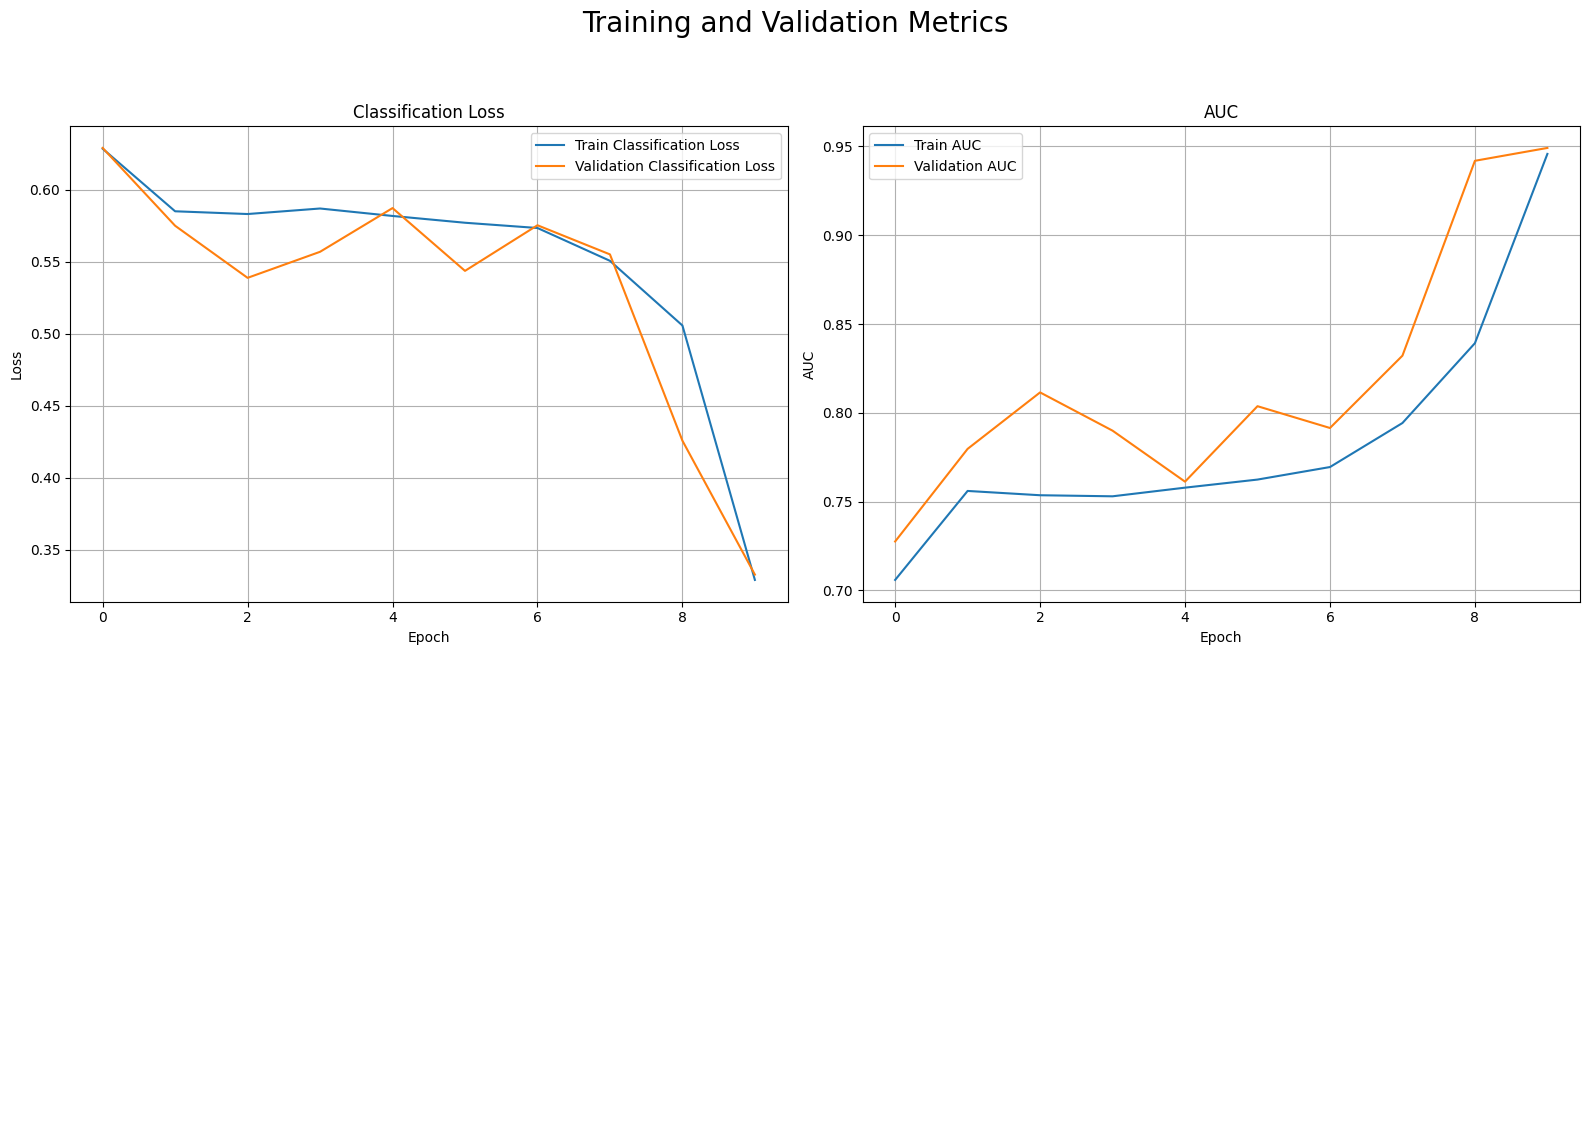

Training history plots generated.
Generating UMAP of latent space...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


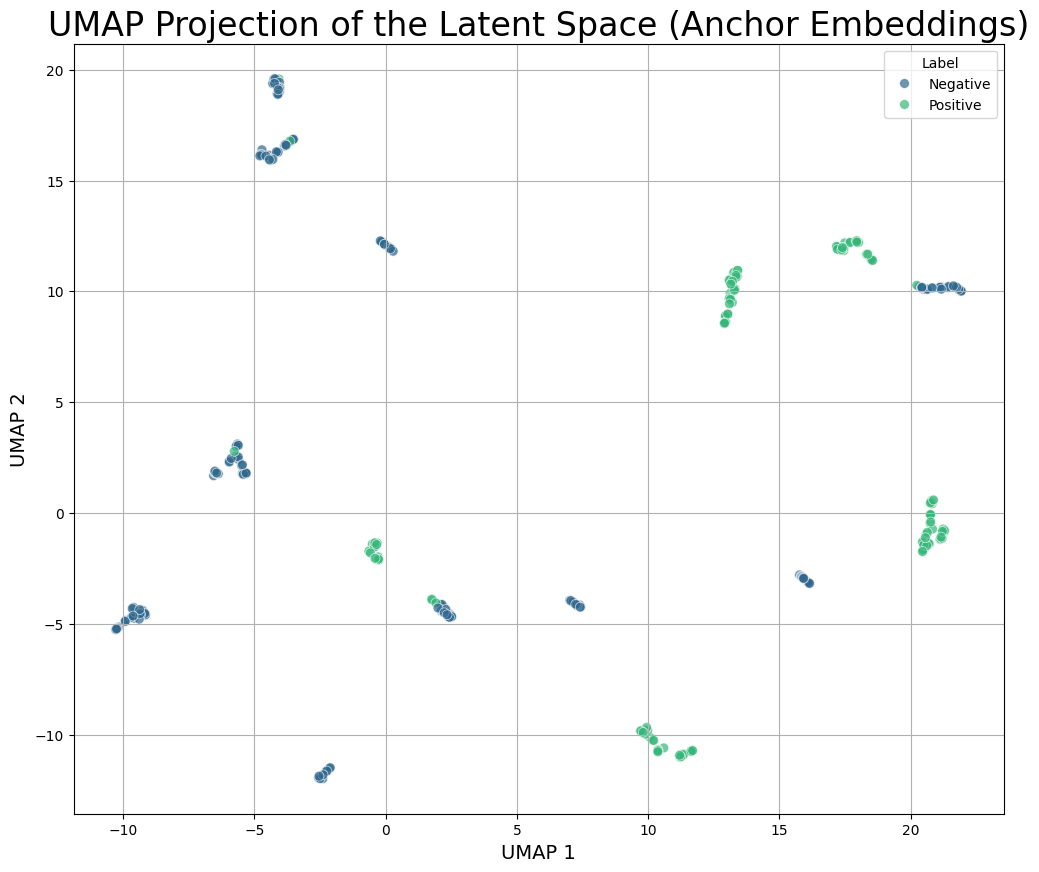

UMAP plot generated.


In [20]:
# ==============================================================================
# 7. PLOT TRAINING HISTORY
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print("Plotting training history...")

# Create a dataframe from history for easier plotting
history_df = pd.DataFrame(history)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training and Validation Metrics', fontsize=20)

# Plot Classification Loss
axes[0, 0].plot(history_df.index, history_df['class_loss'], label='Train Classification Loss')
axes[0, 0].plot(history_df.index, history_df['val_class_loss'], label='Validation Classification Loss')
axes[0, 0].set_title('Classification Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot AUC
axes[0, 1].plot(history_df.index, history_df['auc'], label='Train AUC')
axes[0, 1].plot(history_df.index, history_df['val_auc'], label='Validation AUC')
axes[0, 1].set_title('AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Hide empty subplots
axes[1, 0].axis('off')
axes[1, 1].axis('off')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Training history plots generated.")

# ==============================================================================
# 8. UMAP VISUALIZATION OF LATENT SPACE
# ==============================================================================
# !pip install umap-learn seaborn
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt

print("Generating UMAP of latent space...")

# --- Get latent vectors and labels from the validation set ---
latent_vectors = []
true_labels = []
all_soft_probs = []

for x_val_batch, y_val_batch in val_dataset:
    x_batch_list = [
        x_val_batch['pep_onehot'],
        x_val_batch['pep_mask'],
        x_val_batch['mhc_emb'],
        x_val_batch['mhc_mask'],
    ]
    predictions = model(x_batch_list, training=False)
    latent_vectors.append(predictions['anchor_embeddings'].numpy().reshape(x_val_batch['pep_onehot'].shape[0], -1)) # Flatten anchor embeddings for UMAP
    true_labels.append(y_val_batch['cls_ypred'].numpy())
    #all_soft_probs.append(predictions['soft_cluster_probs'].numpy()) # This output is not in the current model

# Concatenate all batches
latent_vectors = np.concatenate(latent_vectors, axis=0)
true_labels = np.concatenate(true_labels, axis=0).flatten()
#all_soft_probs = np.concatenate(all_soft_probs, axis=0) # This output is not in the current model

# --- Run UMAP ---
# Note: umap-learn needs to be installed (`pip install umap-learn`)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(latent_vectors)

# --- Plot UMAP ---
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=true_labels,
    palette=sns.color_palette("viridis", 2),
    alpha=0.7,
    s=50
)
plt.title('UMAP Projection of the Latent Space (Anchor Embeddings)', fontsize=24)
plt.xlabel("UMAP 1", fontsize=14)
plt.ylabel("UMAP 2", fontsize=14)
handles, _ = scatter.get_legend_handles_labels()
plt.legend(handles, ['Negative', 'Positive'], title='Label')
plt.grid(True)
plt.show()

print("UMAP plot generated.")
# ==============================================================================
# 9. VISUALIZE EXPERT ACTIVATIONS - This output is not in the current model.
# ==============================================================================
# print("Visualizing expert activations...")

# --- Get soft probabilities from the first validation batch ---
# for x_val_batch, y_val_batch in val_dataset.take(1):
#     x_batch_list = [
#         x_val_batch['pep_onehot'],
#         x_val_batch['pep_mask'],
#         x_val_batch['mhc_emb'],
#         x_val_batch['mhc_mask'],
#         x_val_batch['mhc_onehot']
#     ]
#     predictions = model(x_batch_list, training=False)
#     soft_probs = predictions['soft_cluster_probs'].numpy()
#     sample_labels = y_val_batch['cls_ypred'].numpy().flatten()

# Take the first 5 samples for visualization
# sample_probs = soft_probs[:5]
# sample_labels_5 = sample_labels[:5]

# --- Plot heatmap of expert activations ---
# plt.figure(figsize=(15, 5))
# sns.heatmap(sample_probs, annot=True, cmap='viridis', fmt='.3f',
#             yticklabels=[f"Sample {i} (Label: {int(l)})" for i, l in enumerate(sample_labels_5)])
# plt.title('Expert Activation Probabilities (Soft Probs) for 5 Validation Samples')
# plt.xlabel('Expert Index')
# plt.ylabel('Sample Index')
# plt.show()

# print("Expert activation plot generated.")

# ==============================================================================
# 10. VISUALIZE OVERALL EXPERT UTILIZATION - This output is not in the current model.
# ==============================================================================
# print("Visualizing overall expert utilization...")

# --- Calculate total activation for each expert ---
# Sum probabilities for each expert across all validation samples
# expert_utilization = np.sum(all_soft_probs, axis=0)

# --- Plot bar chart of expert utilization ---
# plt.figure(figsize=(18, 7))
# expert_indices = np.arange(num_experts)
# plt.bar(expert_indices, expert_utilization, color='skyblue')
# plt.title('Total Expert Utilization Across Validation Set', fontsize=18)
# plt.xlabel('Expert Index', fontsize=14)
# plt.ylabel('Sum of Soft Probabilities (Activation)', fontsize=14)
# plt.xticks(expert_indices)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

# print("Expert utilization plot generated.")

In [ ]:
# ==============================================================================


Visualizing anchor positions, weights, and barcode attention...


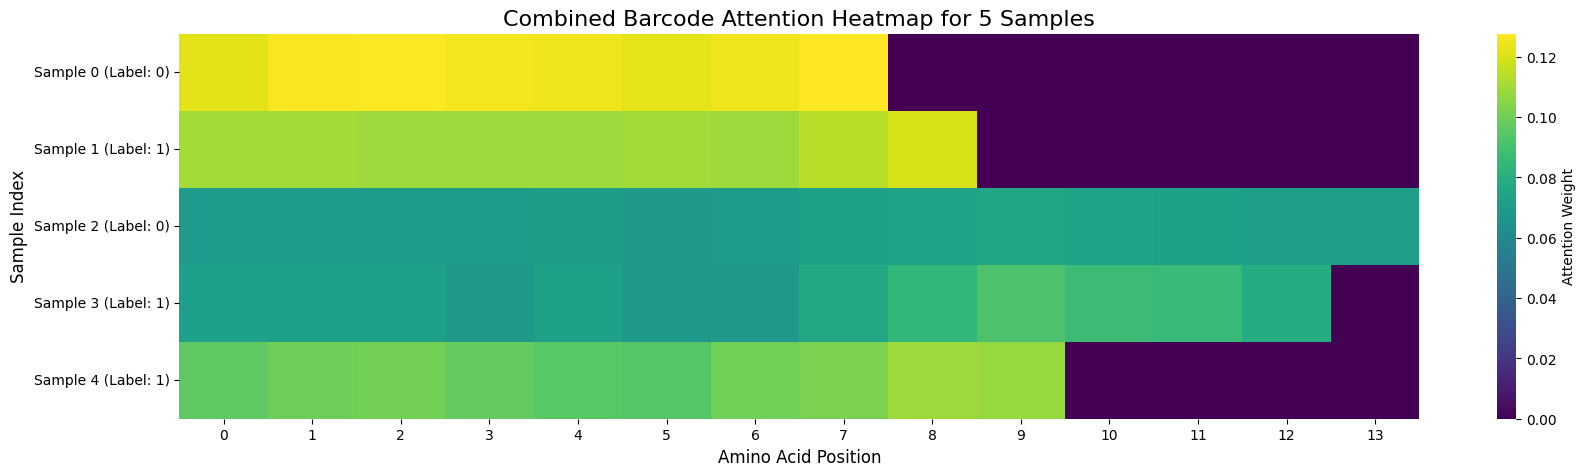

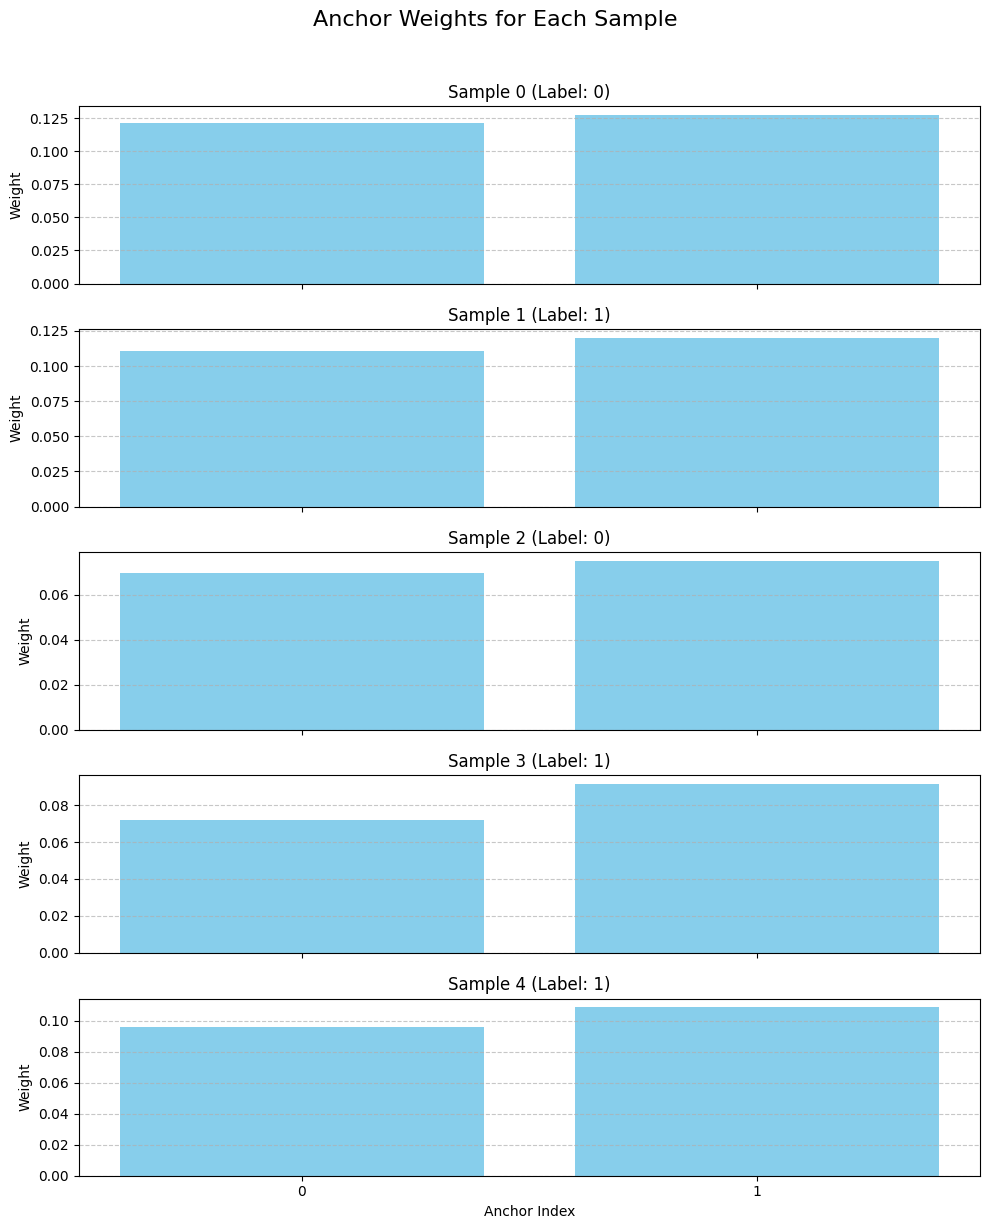


Anchor position, weight, and barcode attention plots generated.


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==============================================================================
# 9. VISUALIZE ANCHOR POSITIONS, WEIGHTS, AND BARCODE ATTENTION
# ==============================================================================
print("Visualizing anchor positions, weights, and barcode attention...")

# --- Get anchor positions, weights, and barcode attention from the first validation batch ---
# This part assumes 'val_dataset' and 'model' are defined and available.
for x_val_batch, y_val_batch in val_dataset.take(1):
    x_batch_list = [
        x_val_batch['pep_onehot'],
        x_val_batch['pep_mask'],
        x_val_batch['mhc_emb'],
        x_val_batch['mhc_mask'],
    ]
    predictions = model(x_batch_list, training=False)
    anchor_positions = predictions['anchor_positions'].numpy()
    anchor_weights = predictions['anchor_weights'].numpy()
    barcode_att = predictions['barcode_att'].numpy() # Shape: (B, 1, N)
    sample_labels = y_val_batch['cls_ypred'].numpy().flatten()

# Take the first few samples for visualization
num_samples_to_plot = 5
sample_anchor_positions = anchor_positions[:num_samples_to_plot]
sample_anchor_weights = anchor_weights[:num_samples_to_plot]
sample_barcode_att = barcode_att[:num_samples_to_plot]
sample_labels_plot = sample_labels[:num_samples_to_plot]

# --- PLOT 1: Combined Barcode Attention Heatmap ---

# Reshape the attention data from (5, 1, N) to (5, N) for the heatmap
combined_attention_weights = np.squeeze(sample_barcode_att, axis=1)

# Create the heatmap figure
plt.figure(figsize=(20, 5))
sns.heatmap(
    combined_attention_weights,
    cmap='viridis',
    cbar_kws={'label': 'Attention Weight'}
)
plt.title('Combined Barcode Attention Heatmap for 5 Samples', fontsize=16)
plt.xlabel('Amino Acid Position', fontsize=12)
plt.ylabel('Sample Index', fontsize=12)
# Set y-tick labels to correspond to sample index and its label
yticklabels = [f'Sample {i} (Label: {int(label)})' for i, label in enumerate(sample_labels_plot)]
plt.yticks(np.arange(num_samples_to_plot) + 0.5, labels=yticklabels, rotation=0)
plt.show()


# --- PLOT 2: Individual Anchor Weights ---

# Create a figure with 5 subplots, one for each sample, arranged vertically
fig, axes = plt.subplots(
    nrows=num_samples_to_plot,
    ncols=1,
    figsize=(10, 12),
    sharex=True # All subplots will share the same x-axis
)
fig.suptitle('Anchor Weights for Each Sample', fontsize=16, y=1.02)

for i in range(num_samples_to_plot):
    ax = axes[i]
    ax.bar(range(len(sample_anchor_weights[i])), sample_anchor_weights[i], color='skyblue')
    ax.set_title(f'Sample {i} (Label: {int(sample_labels_plot[i])})')
    ax.set_ylabel('Weight')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xticks(range(len(sample_anchor_weights[i])))

# Set the common x-axis label for the last subplot
axes[-1].set_xlabel('Anchor Index')

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()
plt.show()


print("\nAnchor position, weight, and barcode attention plots generated.")
